In [16]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

C:\Users\free-\AppData\Local\Temp\ipykernel_16720\1055135546.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [17]:
data = pd.read_csv('train_sem09.csv')

In [3]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#на всякий случай проверим данные на наличие пропусков и убедимся, что их нет
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

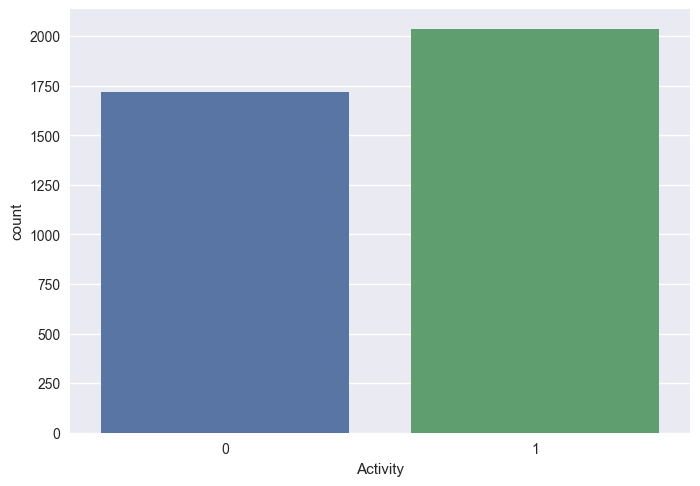

In [5]:
#проверимЯ является ли данные целевого признака сбалансированными
sns.countplot(data=data, x='Activity');

соотношение примерно 45/55, можно считать данные сбалансированными, значит использовать метод 'stratify' при разбиении выборки не нужно.

In [18]:
#Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [19]:
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30. стратифицированное разбиение не требуется, поскольку выборка однородн
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [20]:
#Создаем модель логистической регрессии
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель
log_reg.fit(X_train, y_train)
#предстазываем целевой признак на тестовом наборе
y_pred_LR = log_reg.predict(X_test)
#считаем целевую метрику
print('Test F-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR)))

Test F-score: 0.79


In [21]:
#Создаём объект класса RanndomForest
rf = ensemble.RandomForestClassifier(
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)
#предстазываем целевой признак на тестовом наборе
y_pred_RF = rf.predict(X_test)
#считаем целевую метрику
print('Test F-score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF)))

Test F-score: 0.82


## GridSearchCV


### Подбор гиперпараметров для модели логистической регресии

In [41]:

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации

]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 

y_pred_LR_grid = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 4.97 s
Wall time: 9min 12s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}


In [53]:
#попробуем изменить параметры
param_grid = [
              {'penalty': ['l2', 'l1' 'none', 'elasticnet'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'liblinear', 'saga'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации

]
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 

y_pred_LR_grid = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
280 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\

CPU times: total: 5.42 s
Wall time: 5min 45s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


Как видим, значение целевой метрики не увеличилось

### Подбор гиперпараметров для модели случайного леса

In [42]:
param_grid = {
        'n_estimators': [100, 200, 300, 400, 500], #максимальная глубина дерева
        'criterion': ['gini', 'entropy'], # критерий информативности разбиения для каждого из деревьев
        'max_depth': [5, 7, 9, 11, 13, 15] # максимальная глубина одного дерева
              } 
       
grid_search_2 = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 

y_pred_RF_grid = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: total: 3.3 s
Wall time: 4min 48s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 500}


## RandomizedSearchCV

### Подбор гиперпараметров для модели логистической регресии

In [43]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 

y_pred_LR_rand = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_rand)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 1.14 s
Wall time: 5min 25s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.89}


### Подбор гиперпараметров для модели случайного леса

In [44]:

param_distributions = {'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
              'criterion': ['gini', 'entropy'],
               'max_depth': list(np.linspace(5, 15, 6, dtype=int))},
            
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 

y_pred_RF_rand = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_rand)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.84 s
Wall time: 1min 6s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 500, 'max_depth': 13, 'criterion': 'entropy'}


## Hyperopt

### Подбор гиперпараметров для модели логистической регресии

In [37]:
space={'penalty': hp.choice(label='penalty', options=['l2', 'none']),
       'solver': hp.choice(label='solver', options=['lbfgs', 'sag']),
       'C' : hp.quniform('C', 1, 100, 10) 
      }

# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': int(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

  5%|▌         | 1/20 [00:02<00:53,  2.82s/trial, best loss: -0.734938919248375]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 2/20 [00:12<02:07,  7.08s/trial, best loss: -0.7581461139202956]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 15%|█▌        | 3/20 [00:15<01:26,  5.11s/trial, best loss: -0.7581461139202956]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 4/20 [00:25<01:54,  7.15s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 25%|██▌       | 5/20 [00:28<01:22,  5.51s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 6/20 [00:38<01:38,  7.04s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▌      | 7/20 [00:48<01:43,  7.99s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 40%|████      | 8/20 [00:51<01:15,  6.26s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 45%|████▌     | 9/20 [00:54<00:59,  5.43s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 10/20 [01:04<01:08,  6.84s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 55%|█████▌    | 11/20 [01:07<00:49,  5.53s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 12/20 [01:17<00:55,  6.96s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 65%|██████▌   | 13/20 [01:19<00:39,  5.61s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 14/20 [01:30<00:42,  7.10s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 15/20 [01:40<00:39,  7.99s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

 80%|████████  | 16/20 [01:43<00:25,  6.38s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 17/20 [01:53<00:22,  7.49s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [02:03<00:16,  8.36s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 19/20 [02:14<00:09,  9.06s/trial, best loss: -0.7581515839942384]

c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



100%|██████████| 20/20 [02:17<00:00,  6.90s/trial, best loss: -0.7581515839942384]
Наилучшие значения гиперпараметров {'C': 20.0, 'penalty': 0, 'solver': 1}


In [38]:
pen=['l2', 'none']
sol=['lbfgs', 'sag']

In [39]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=int(best['C'])
)
model.fit(X_train, y_train)
y_pred_LR_hyp = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_hyp)))

f1_score на тестовом наборе: 0.79


c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Подбор гиперпараметров для модели случайного леса

In [46]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 5),
       'max_depth' : hp.quniform('max_depth', 5, 15, 2),
       'criterion': hp.choice(label='criterion', options=['log_loss', 'gini', 'entropy'])
      }

In [47]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'criterion': params['criterion']
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [48]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [03:45<00:00, 11.30s/trial, best loss: -0.812297803095602] 
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 12.0, 'n_estimators': 215.0}
CPU times: total: 22.5 s
Wall time: 3min 45s


In [50]:
crit=['log_loss', 'gini', 'entropy']

In [51]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    criterion=crit[best['criterion']]
)
model.fit(X_train, y_train)
y_pred_RF_hyp = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_hyp)))

f1_score на тестовом наборе: 0.82


## Optuna

### Подбор параметров для модели случайного леса

In [29]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 5)
  max_depth = trial.suggest_int('max_depth', 5, 15, 2)
  criterion = trial.suggest_categorical('criterion', ['log_loss', 'gini', 'entropy'])

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          criterion=criterion,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  #score = metrics.f1_score(y_test,  y_pred_RF_optuna)

  return score

In [30]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-12 10:48:37,652] A new study created in memory with name: RandomForestClassifier
[I 2023-07-12 10:48:47,779] Trial 0 finished with value: 0.8103260225899016 and parameters: {'n_estimators': 265, 'max_depth': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.8103260225899016.
[I 2023-07-12 10:48:52,955] Trial 1 finished with value: 0.8058942177276703 and parameters: {'n_estimators': 105, 'max_depth': 15, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8103260225899016.
[I 2023-07-12 10:48:56,703] Trial 2 finished with value: 0.796481852119716 and parameters: {'n_estimators': 110, 'max_depth': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.8103260225899016.
[I 2023-07-12 10:49:12,520] Trial 3 finished with value: 0.8100334922800441 and parameters: {'n_estimators': 405, 'max_depth': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8103260225899016.
[I 2023-07-12 10:49:31,821] Trial 4 finished with value: 0.8094717192041893 and parameters: {'n_esti

CPU times: total: 28.6 s
Wall time: 3min 41s


In [31]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 355, 'max_depth': 15, 'criterion': 'gini'}


In [32]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_pred_RF_opt = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_opt)))

f1_score на тестовом наборе: 0.82


### Подбор параметров для модели логистической регрессии

In [33]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  C = trial.suggest_int('C', 1, 100, 10)
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [34]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-07-12 10:53:31,281] A new study created in memory with name: LogisticRegression
c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(
c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not con

CPU times: total: 19.7 s
Wall time: 2min 25s


In [35]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'C': 1, 'penalty': 'l2', 'solver': 'sag'}


In [36]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_pred_LR_opt = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_opt)))

f1_score на тестовом наборе: 0.79


c:\Users\free-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Подведем итоги

In [52]:
print('Test F-score логистическая регресия без подбора гиперпараметров: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR)))
print('Test F-score случайный лес без подбора гиперпараметров: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF)))
print('Test F-score логистическая регрессия подбор гиперпараметров с помощью GridSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_grid)))
print('Test F-score случайный лес подбор гиперпараметров с помощью GridSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_grid)))
print('Test F-score логистическая регрессия подбор гиперпараметров с помощью RandomizedSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_rand)))
print('Test F-score случайный лес подбор гиперпараметров с помощью RandomizedSearchCV: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_rand)))
print('Test F-score логистическая регрессия подбор гиперпараметров с помощью Hyperopt: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_hyp)))
print('Test F-score случайный лес подбор гиперпараметров с помощью Hyperopt: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_hyp)))
print('Test F-score случайный лес подбор гиперпараметров с помощью Optuna: {:.2f}'.format(metrics.f1_score(y_test, y_pred_RF_opt)))
print('Test F-score логистическая регрессия подбор гиперпараметров с помощью Optuna: {:.2f}'.format(metrics.f1_score(y_test, y_pred_LR_opt)))

Test F-score логистическая регресия без подбора гиперпараметров: 0.79
Test F-score случайный лес без подбора гиперпараметров: 0.82
Test F-score логистическая регрессия подбор гиперпараметров с помощью GridSearchCV: 0.79
Test F-score случайный лес подбор гиперпараметров с помощью GridSearchCV: 0.82
Test F-score логистическая регрессия подбор гиперпараметров с помощью RandomizedSearchCV: 0.79
Test F-score случайный лес подбор гиперпараметров с помощью RandomizedSearchCV: 0.82
Test F-score логистическая регрессия подбор гиперпараметров с помощью Hyperopt: 0.79
Test F-score случайный лес подбор гиперпараметров с помощью Hyperopt: 0.82
Test F-score случайный лес подбор гиперпараметров с помощью Optuna: 0.82
Test F-score логистическая регрессия подбор гиперпараметров с помощью Optuna: 0.79


Мы видим, что подбор гиперпараметров в данном случае не дал результатов для обеих моделей. То есть параметры по умолчанию являются оптимальными.